In [1]:
import matplotlib
import matplotlib.pyplot as plt
import mrlattice.lattice as lat
from mrlattice.lattice import LatticeArray

FIXED_WIDTH = lat.configure.LatticeArrayScheme.FIXED_WIDTH_SCHEME
FIXED_NUMBER = lat.configure.LatticeArrayScheme.FIXED_NUMBER_SCHEME

In [2]:
# this notebook requires mrlattice version:
VERSION = "0.1.2"

In [3]:
%run prepare_notebook.ipynb

The following names are now available:

<class '__main__.LatticeArrayPlotWidget'>


In [4]:
%load_ext jupyter_spaces

In [5]:
# interactive plots in notebook
# %matplotlib notebook
# open external window with plot
# %matplotlib qt
# for saving widget state
%matplotlib inline

if "inline" in matplotlib.get_backend():
    plt.rcParams["figure.figsize"] = (14, 14)
else:
    plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Summary

We derive a set of restrictions for the finest width and number of repetitions that guarantee strict double cell tips when superimposing two diagonal borders latices. We follow the same considerations as previously for the pulse shaped lattices.


# Double Cell Tips

Previously, we already solved the problem of double cell tips for region cusps for the setting of lattice pulses (see `early_prototyping/lattice_array_0-9.ipynb`). Our goal in this notebook is to apply the same considerations to the diagonal borders lattices. Again, we want to superimpose two lattices where one of them is spatially mirrored. We know that for strict double cell tips, the spatial size of the lattices to superimpose needs to fit an integer number of cells with resolutions one step (2x) coarser than the coarsest cell on the lattice. The pictures below show this fact for the diagonal borders lattices in consideration. Here we chose to mirror the lattices in temporal direction before superimposing, because this gives us the already well studied type of coarse to fine transitions.
#### Red grid of one step coarser fits in spatial direction
![](imgs/diag_borders_superpose_good.png)
#### Red grid of one step coarser doesn't fit in spatial direction
![](imgs/diag_borders_superpose_bad.png)


## Restrictions for the Properties

Our next goal is to formalize the restrictions for double cell tips for the diagonal borders lattice. Out of the five parameters we now have to choose which to restrict. Choosing the same as before seems to be an easy way out. Restricting the `finest_width` will be necessary in order to compensate the spatial size of the boarders regions. Restricting `repeat` instead of `buffer` (=width of coarsest region) leaves `buffer` free which is a more natural parameter to adjust the spatial size of the entire lattice. The other way around, `repeat` would be the parameter that sets the spatial width (in order to fit enough repetitions). In both variants the `finest_width` is of corse still available to adjust the spatial size, though restricted.

### Restricting `finest_width`

![](imgs/diag_borders_dct_calc.png)

We will derive the formulas for the "fixed_width" (=Kayran) scheme and just present the formulas for the "fixed_number" (Ipp) scheme, as the latter are a bit simpler.

#### Fixed Width (Kayran) Scheme
We know what we have to do. First we calculate the width of the coarsening regions marked in red
\begin{equation}
\sum {borders}_{red} = \sum_{coa=1}^{coarse\_steps-1} (borders\_width\, //\, 2^{coa} + 1)\, 2^{coa}.
\end{equation}
Then we calculate the necessary width of the finest region (in yellow), so that the sum of both is modulo the coarsest resolution (in green)
\begin{equation}
\sum {finest\_width}_{yellow} = 2^{coarse\_steps} - \frac{\sum_{coa=1}^{coarse\_steps-1} (\frac{borders\_width}{//\, 2^{coa}} + 1)\, 2^{coa}}{\%\, 2^{coarse\_steps}}.
\end{equation}
To ensure that the width of the finest region stays modulo the coarsest region, the stepping for `finest_width` needs to be set to $2^{coarse\_steps}$.

Next is the number of repetitions. We know that each repetition adds one cell of size $2^{coarse\_steps}$. For a single repetition the number of cells of that size is given by the `buffer`. So we need to subtract 1 from the number of repetions and add the size of the buffer to get the number of all cells of size $2^{coarse\_steps}$.
\begin{equation}
\sum {coarsest} = (buffer + repeat -1)*2^{coarse\_steps}
\end{equation}
If we now demand that the total spatial width $\sum {coarsest} + \sum {borders}_{red} + \sum {finest\_width}_{yellow}$ is modulo $2^{coarse\_steps+1}$, the size of one step coarser cells. We can rearrange for the minmal repeat (number of repetitions)
\begin{align}
repeat *2^{coarse\_steps} &= 2^{coarse\_steps+1} - \frac{(buffer-1)*2^{coarse\_steps} - \sum {finest\_width}_{yellow} - \sum {borders}_{red}}{\%\, 2^{coarse\_steps+1}}, \\
repeat &= 2 - \frac{1}{2^{coarse\_steps}} \frac{(buffer-1)*2^{coarse\_steps} - \sum {finest\_width}_{yellow} - \sum {borders}_{red}}{\%\, 2^{coarse\_steps+1}}.
\end{align}

Without further simplifying this expression we can already see that repeat will either be 1 or 2. The nominator of the fraction on the right hand side is a multiple of $2^{coarse\_steps}$. So the remainder will either be 0 if the multiple is even or 1 if it is uneven. In order to fulfill the equation modulo $2^{coarse\_steps+1}$ we have to set the stepping of repeat to 2. This ensures that adding a repeat step, which translates to adding cells of size $2^{coarse\_steps}$ always adds two cells of this size and upholds the modulo condition.

However, there is a problem. The minimal value for repeat calculated above is not representative of the lattice in the sense that for this value the lattice is to short in temporal direction to show the double cell tips. Furthermore we would like to have at least as many repetitions as is necessary to show the double cell tip for the coarsest region. These two images show the desired output. Again, this is very similar to what we already argued for the pulse shaped lattices.
<table><tr><td><img src="imgs/diag_borders_repeat-1.png" width="100%"/></td><td><img src="imgs/diag_borders_repeat-2.png" width="100%"/></td></tr></table>


It then becomes obvious, that the areas marked in red and green have to be the same size. If the red area is larger than the green area, the coarsest cells would not exist, as then they would get overlayed by finer cells. If the green are is larger there will be more time slices that contain the coarsest cells. This condition also gets us double cell tips for the coarsest region. With this in mind we update our formula for the minmal repeat
\begin{equation}
repeat = \frac{\sum {borders}_{red} + \sum {finest\_width}_{yellow}}{//\, 2^{coarse\_steps}} + 1 + \frac{buffer}{\%\, 2}.
\end{equation}
In this formula the +1 comes from the one cell of coarsest resolution in the red area. The correction term with the width of the buffer results from the fact, that depending on wether the buffer is odd or even, repeat needs to be the opposite. Otherwise double cell tips cannot happen. In the plotted results down below it is clear that repeat gives the number of coarsest cells minus (buffer-1) for the first time slice.

#### Fixed Number (Ipp) Scheme

Only $\sum {borders}_{red}$ needs to be adjusted. $\sum {finest\_width}_{yellow}$ and repeat can stay functionally the same.
\begin{align}
\sum {borders}_{red} &= (borders\_width + 1)\, \sum_{coa=1}^{coarse\_steps-1}\, 2^{coa}, \\
\sum {finest\_width}_{yellow} &= 2^{coarse\_steps} - \frac{\sum {borders}_{red}}{\%\, 2^{coarse\_steps}}, \\
repeat &= \frac{\sum {borders}_{red} + \sum {finest\_width}_{yellow}}{//\, 2^{coarse\_steps}} + 1 + \frac{buffer}{\%\, 2}.
\end{align}


### Code

We extend the LatticeArray class and overwrite the two funcions responsible for propagating property changes and updating all other properties. The order in which we update the properties is important. Later code steps must not change properties that were used in previous steps to set other properties as then their final value could deviate from the value used for calculating other properties. The code below only restricts the parameters of the diagonal borders lattices. There is no superpostition code yet. All images in this notebook are created differently, if they are not the direct output of code.

In [6]:
class SuperimposeLatticeArray(LatticeArray):
    
    def _update_props_fixed_width(self):
        
        # resolution of coarsest
        steps_power = 2 ** self.coarse_steps.value

        # configure borders_width
        self.borders_width._step = 2
        self.borders_width._min = steps_power
        self.borders_width._check_bounds_and_update()
        
        # width of coarsening regions
        regions_sum = sum(
            2 ** coa * (self.borders_width.value // 2**coa +1)
            for coa in range(1, self.coarse_steps.value)
        )

        # configure finest_width
        self.finest_width._step = steps_power
        self.finest_width._min = steps_power - regions_sum % steps_power
        self.finest_width._check_bounds_and_update()

        # configure repetitions
        self.repeat._step = 2
        self.repeat._min = (regions_sum + self.finest_width.value)// steps_power + 1 + self.buffer.value%2
        self.repeat._check_bounds_and_update()
        
    def _update_props_fixed_number(self):
        
        # resolution of coarsest
        steps_power = 2 ** self.coarse_steps.value
        
        # configure borders_width
        self.borders_width._step = 1
        self.borders_width._min = 2
        self.borders_width._check_bounds_and_update()

        # width of coarsening regions
        regions_sum = (1 + self.borders_width.value) * sum(
            2 ** coa for coa in range(1, self.coarse_steps.value)
        )
        
        # configure finest_width
        self.finest_width._step = steps_power
        self.finest_width._min = steps_power - regions_sum % steps_power
        self.finest_width._check_bounds_and_update()

        # configure repetitions
        self.repeat._step = 2
        self.repeat._min = (regions_sum + self.finest_width.value)// steps_power + 1 + self.buffer.value%2
        self.repeat._check_bounds_and_update()  

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

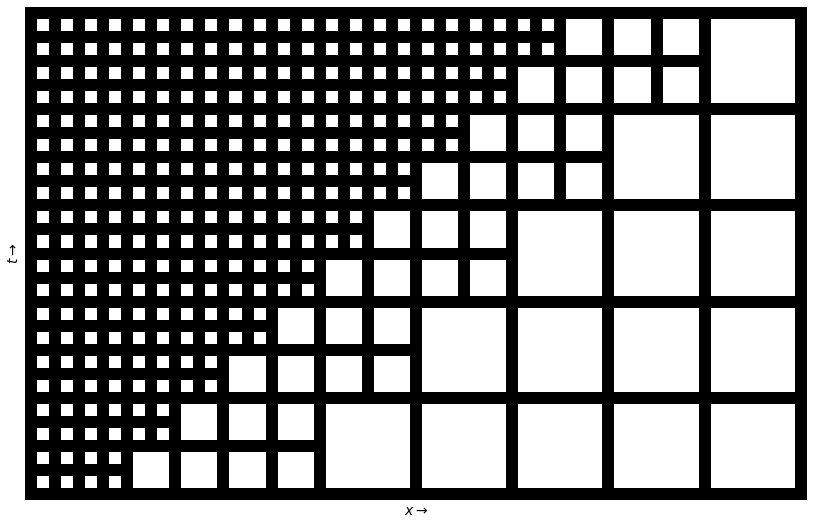

In [7]:
LatticeArrayPlotWidget(
    lattice=SuperimposeLatticeArray(
        scheme=FIXED_WIDTH, coarse_steps=2, borders_width=6, finest_width=4
    ))
# flip temporal, flip spatial

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

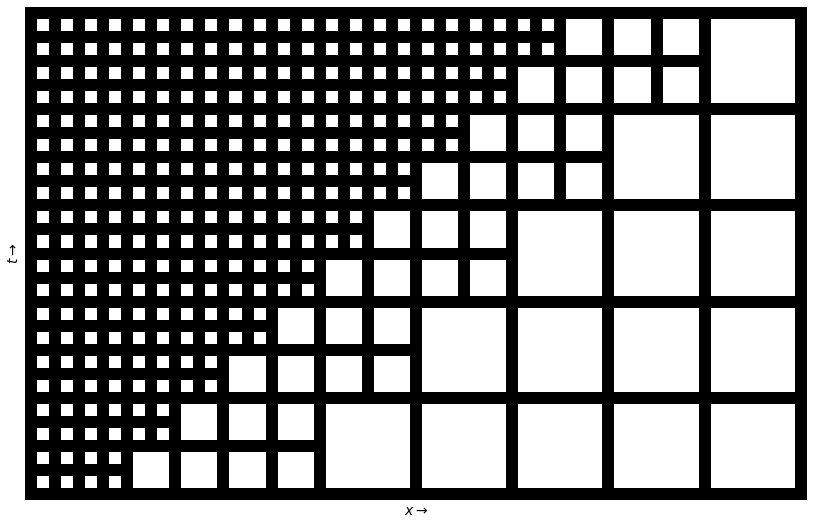

In [8]:
LatticeArrayPlotWidget(
    lattice=SuperimposeLatticeArray(
        scheme=FIXED_NUMBER, coarse_steps=2, borders_width=3, finest_width=4
    ))
# flip temporal, flip spatial

## Excluded Configurations

![](imgs/diag_borders_coarse_prevail.png)
As a final note we want to mention that configurations with the geometry of the image above are excluded. Compared to the other lattice configurations, here a fine region is surrounded by coarsening regions. This geometry doesn't appear in pulses (see late notebooks `early_prototyping/`). It can be generated by superimposing two diagonal borders lattices and applying the rule that coarser cells prevail over finer ones. This is the exact opposite of the rule applied until now, where finer cells take precedence over coarser cells. We also want to stress, that the restrictions for double cell tips as discussed in this notebook don't lead to double cell tips for this alternate lattice configurations.